## SpaGFT Tutorial：Visium Human Lymph Node

### Outline
1. Import packages
2. Load Visium data
3. QC and preprocessing
4. Function: identify spatially variable genes
5. Function: characterize tissue modules
6. Function: gene expression enhancement

The installation steps can be found [here](https://spagft.readthedocs.io/en/latest/Installation.html).
SpaGFT is a python package to analyze spatial transcriptomics data. To install SpaGFT, the python version is required to >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.8.0'

### 1. Import packages

In [2]:
import SpaGFT as spg
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt

sc.settings.verbosity = 3      
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 louvain==0.7.1 pynndescent==0.5.7


Define the folder to save the results:

In [3]:
results_folder = './results/lymph_nodes_analysis/'

### 2. Load Visium data

In this tutorial, we use a public available Visium dataset of the human lymph node. The dataset could be downloaded easily by [scanpy](https://scanpy.readthedocs.io/en/stable/). Two key elements are essential for running SpaGFT, including the raw gene count matrix and spatial coordinates of spots. The basis object inputting to SpaGFT should be an _anndata_ object which contains the above two elements.

In [4]:
# Load data
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
# Add raw to anndata object
adata.raw = adata

reading /home/frank/Downloads/SpaGFT-master/source/spatial/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5
 (0:00:00)


Users can also create your _anndata_ object `adata`, which contains their own datasets. Note that the raw count matrix should be found in `adata.X`, and the spatial coordinates of all spots should be found in `adata.obs` or `adata.obsm`. Users can use other functions provided by scanpy to create the _anndata_ object as follows:
```
sc.read_visium()
```
Alternatively, users can also create the _anndata_ object using the raw count matrix and spatial coordinates of spots. For example:
```
count_mtx = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
coord_mtx = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x', 'y'])
count_mtx.iloc[:5, :5]
coord_mtx.iloc[:5, :5]
```
create _anndata_ object by
```
adata = sc.AnnData(count_mtx)
adata.obs[['x', 'y']] = coord_mtx
adata.var_names_make_unique()
adata.raw = adata
```

### 3. QC and preprocessing

Users can normalize Visium counts data with the built-in normalize_total method from scanpy recommendation and filter genes which express less than ten spots. In addition, users can also customize preprocessing schemes. Each gene in `adata.var_names` should express at least one spot.

In [5]:
# QC
sc.pp.filter_genes(adata, min_cells=10)
# Normalization
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

filtered out 16788 genes that are detected in less than 10 cells
normalizing counts per cell
    finished (0:00:00)


### 4. Function: identify spatially variable genes

SpaGFT identifies spatially variable genes (SVGs) by graph Fourier transform. There are four key parameters:
1. _ratio_low_freq_: this parameter controls how many the low-frequency Fourier modes (FM) used. Herein, the number of FMs is defined as _ratio_low_freq_ * $\sqrt{n}$ to measure spatial patterns.

2. _ratio_high_freq_: this parameter controls how many the high-frequency Fourier modes (FM) used. Herein, the number of FMs is defined as _ratio_high_freq_ * $\sqrt{n}$ to measure noises.

3. _ratio_neighbors_: this parameter determines the $K$ when construct KNN graph by $K=$ratio_neighbors * $\sqrt{n}/2$. 

Note that setting a large number of _ratio_low_freq_ and _ratio_low_freq_ may be time consuming.


If spatial coordinate information of all spots in `adata.obsm`, users can set `spatial_info` in `spg.rank_gene_smooth` as the key in `adata.obsm.keys()`, indicating spatial coordinates. Otherwise, set `spatial_info` as the columns in `adata.obs.columns()` to indicate spatial coordinates.

In [6]:
gene_df = spg.rank_gene_smooth(adata,
                               ratio_low_freq=0.5,
                               ratio_high_freq=3,
                               ratio_neighbors=1,
                               spatial_info=['array_row', 'array_col'])

Graph Fourier Transform finished!
SVG ranking could be found in adata.var['svg_rank']
The spatially variable genes judged by gft_score could be found 
          in adata.var['cutoff_gft_score']
Gene signals in frequency domain when detect SVGs could be found
          in adata.varm['freq_domain_svg']


In [7]:
gene_df.iloc[:5, :]

gene_ids    feature_types  genome  n_cells  gft_score  \
TMSB4X  ENSG00000205542  Gene Expression  GRCh38     4033   6.814512   
EEF1A1  ENSG00000156508  Gene Expression  GRCh38     4031   6.389332   
MT-CO2  ENSG00000198712  Gene Expression  GRCh38     4030   6.176624   
IFI44L  ENSG00000137959  Gene Expression  GRCh38     1882   5.931681   
MT-CO1  ENSG00000198804  Gene Expression  GRCh38     4024   5.904822   

        svg_rank  cutoff_gft_score        pvalue        qvalue  
TMSB4X         1              True  7.736596e-38  3.086732e-34  
EEF1A1         2              True  2.281886e-37  5.319321e-34  
MT-CO2         3              True  7.736596e-38  3.086732e-34  
IFI44L         4              True  7.736596e-38  3.086732e-34  
MT-CO1         5              True  7.736596e-38  3.086732e-34

The SVGs can be exported by 

In [8]:
svg_list = gene_df[gene_df.cutoff_gft_score][gene_df.qvalue < 0.05].index.tolist()
print(svg_list[:5])
print(len(svg_list))

['TMSB4X', 'EEF1A1', 'MT-CO2', 'IFI44L', 'MT-CO1']
1490


We can visualize gene expression on spots as below:

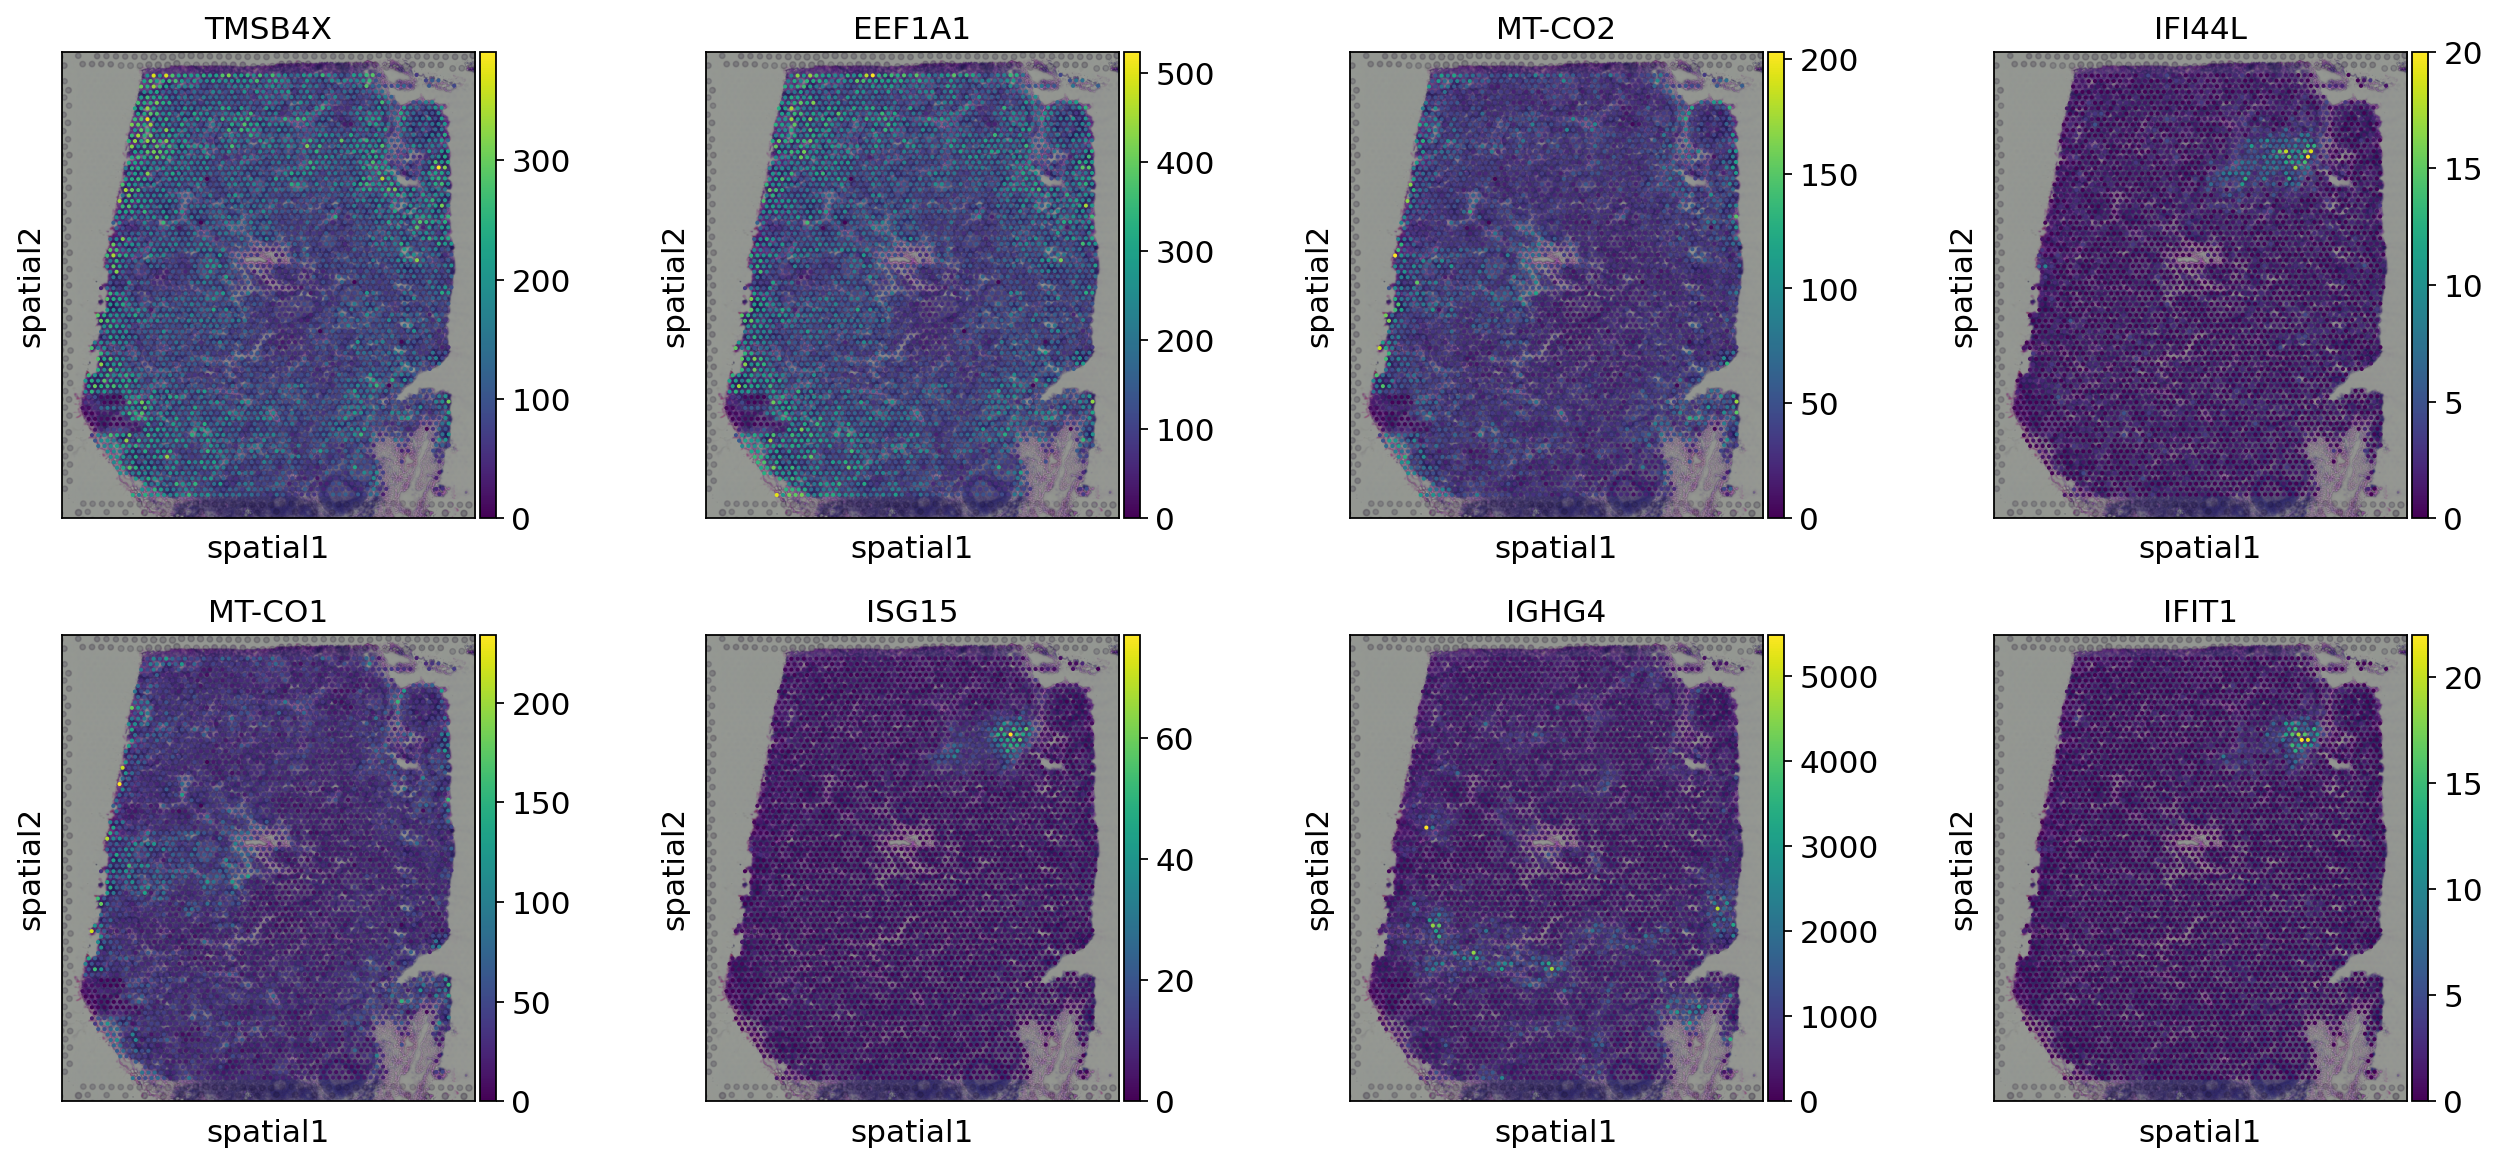

In [9]:
# top 8 SVGs according to gft_score
sc.pl.spatial(adata, color=svg_list[:8])

### 5. Function: characterize tissue modules

One of the core functions of SpaGFT is to characterize tissue modules (TMs). SpaGFT clusters SVGs shared with similar spatial patterns in the same group based on low-frequency FM signals.

In [10]:
# detect tissue_module
spg.gft.find_tissue_module(adata, 
                          ratio_fms=2,
                          ratio_neighbors=1,
                          quantile=0.85)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package

In [11]:
# tissue module information can be found in adata.var, where 'tissue_module' in adata.var indicates the gene groups which genes belong to.
# and a group SVGs can reaveals a tissue module
gene_df = adata.var
gene_df = gene_df.loc[svg_list, :]
gene_df.iloc[:10, :]

gene_ids    feature_types  genome  n_cells  gft_score  \
TMSB4X  ENSG00000205542  Gene Expression  GRCh38     4033   6.814512   
EEF1A1  ENSG00000156508  Gene Expression  GRCh38     4031   6.389332   
MT-CO2  ENSG00000198712  Gene Expression  GRCh38     4030   6.176624   
IFI44L  ENSG00000137959  Gene Expression  GRCh38     1882   5.931681   
MT-CO1  ENSG00000198804  Gene Expression  GRCh38     4024   5.904822   
ISG15   ENSG00000187608  Gene Expression  GRCh38     3054   5.767193   
IGHG4   ENSG00000211892  Gene Expression  GRCh38     4034   5.755907   
IFIT1   ENSG00000185745  Gene Expression  GRCh38      828   5.660028   
MT-CO3  ENSG00000198938  Gene Expression  GRCh38     4030   5.613620   
IGLON5  ENSG00000142549  Gene Expression  GRCh38       14   5.604165   

        svg_rank  cutoff_gft_score        pvalue        qvalue tissue_module  \
TMSB4X         1              True  7.736596e-38  3.086732e-34             5   
EEF1A1         2              True  2.281886e-37  5.319321e-34             5   
MT-CO2         3              True  7.736596e-38  3.086732e-34             5   
IFI44L         4              True  7.736596e-38  3.086732e-34             9   
MT-CO1         5              True  7.736596e-38  3.086732e-34             5   
ISG15          6              True  7.736596e-38  3.086732e-34             9   
IGHG4          7              True  7.736596e-38  3.086732e-34             3   
IFIT1          8              True  7.736596e-38  3.086732e-34             9   
MT-CO3         9              True  7.736596e-38  3.086732e-34             5   
IGLON5        10              True  2.830578e-37  5.387668e-34             2   

       sub_TM  
TMSB4X      1  
EEF1A1      1  
MT-CO2      2  
IFI44L      2  
MT-CO1      2  
ISG15       2  
IGHG4       3  
IFIT1       2  
MT-CO3      2  
IGLON5      1

Users can also obtain pseudo expression or binary region information of these TMs as below:

In [12]:
# pseudo expression
tm_expression_df = adata.obsm['tm_pseudo_expression']
tm_expression_df.iloc[:5, :]

tm_1       tm_2        tm_3        tm_4        tm_5  \
AAACAAGTATCTCCCA-1  478.870972   5.768321  248.981964  303.233459  496.288422   
AAACAATCTACTAGCA-1  488.343719   6.579251  170.098328  335.943756  535.488281   
AAACACCAATAACTGC-1  623.501160  11.901285  326.147186  377.745453  591.167542   
AAACAGAGCGACTCCT-1  582.537354   9.534161  179.567947  332.358521  563.559021   
AAACAGCTTTCAGAAG-1  490.854095   6.068426  169.247314  320.944550  577.054504   

                          tm_6        tm_7        tm_8        tm_9  
AAACAAGTATCTCCCA-1  113.108414   84.843697  133.886765   68.094154  
AAACAATCTACTAGCA-1  116.342194  156.439758   96.782188   77.191925  
AAACACCAATAACTGC-1  160.154358  111.237183  185.345245  106.265610  
AAACAGAGCGACTCCT-1  152.363831  104.105347  156.960541  201.376556  
AAACAGCTTTCAGAAG-1  108.769516   68.237411  167.425552   85.061920

In [13]:
# Binary region
tm_binary_df = adata.obsm['tm_binary']
tm_binary_df.iloc[:5, :]

tm_1 tm_2 tm_3 tm_4 tm_5 tm_6 tm_7 tm_8 tm_9
AAACAAGTATCTCCCA-1    0    0    1    0    0    0    0    0    0
AAACAATCTACTAGCA-1    0    0    0    1    1    0    1    0    0
AAACACCAATAACTGC-1    1    1    1    1    1    1    1    1    1
AAACAGAGCGACTCCT-1    1    0    0    1    1    1    0    1    1
AAACAGCTTTCAGAAG-1    0    0    0    1    1    0    0    1    1

Users can visualize TMs on spots as below:
1. pseudo-expression

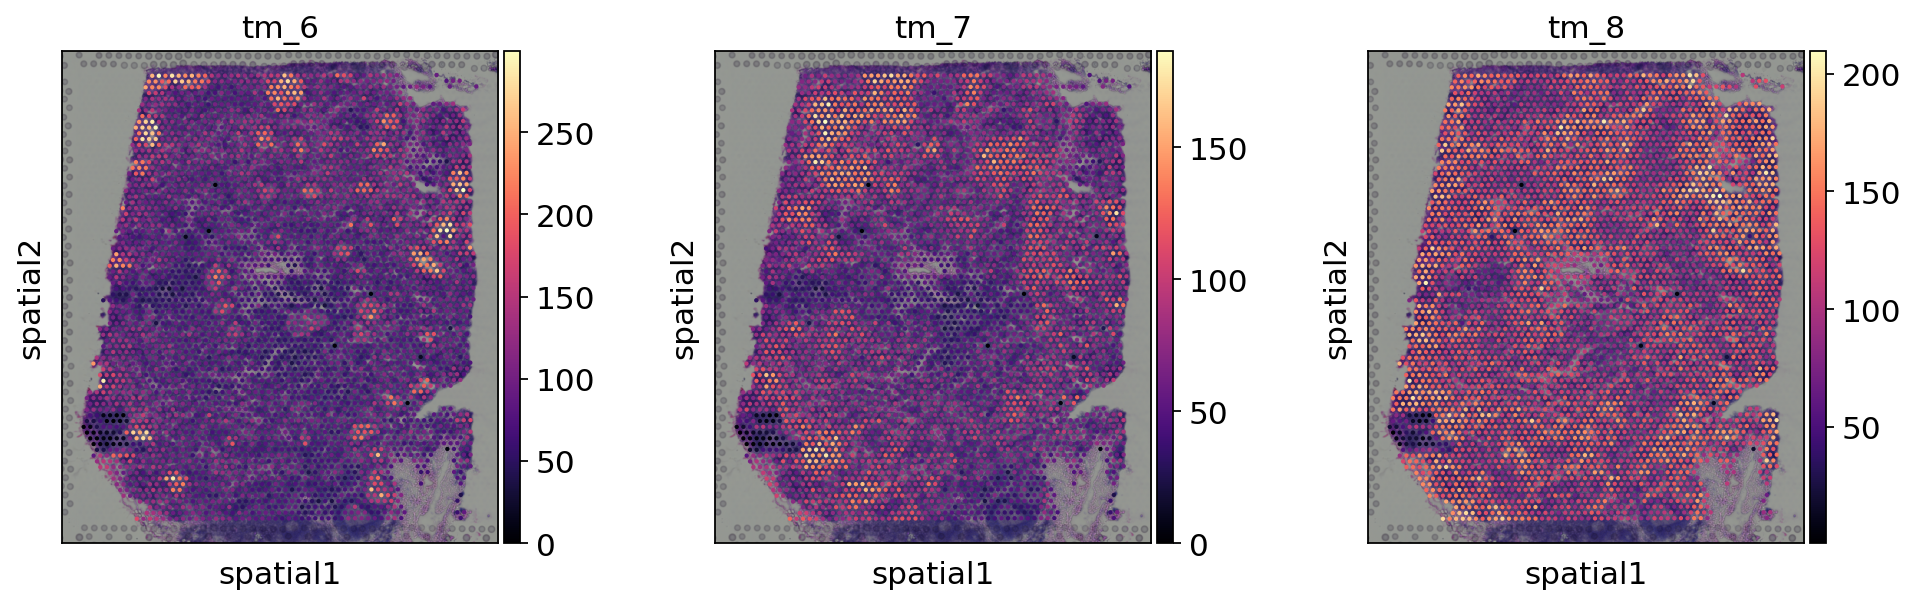

In [14]:
adata.obs[tm_expression_df.columns] = tm_expression_df
sc.pl.spatial(adata, color=['tm_6', 'tm_7', 'tm_8'], cmap='magma')

2. binary form

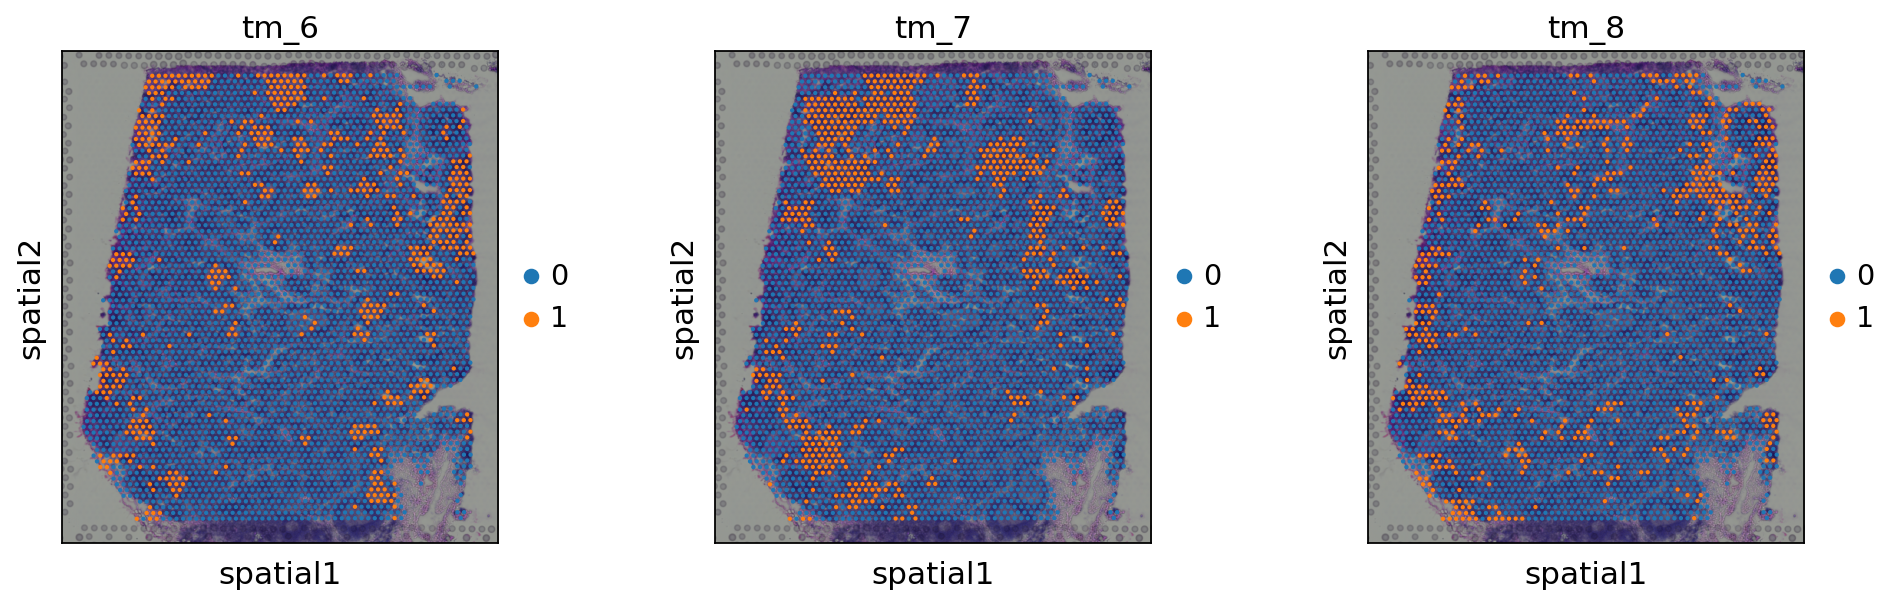

In [15]:
tm_binary_df = tm_binary_df.astype(int)
tm_binary_df = tm_binary_df.astype(str)
adata.obs[tm_binary_df.columns] = tm_binary_df
sc.pl.spatial(adata, color=['tm_6', 'tm_7', 'tm_8'], cmap='RdYlBu_r')

In [16]:
# save SVG information as well as tissue module
results_df = adata.obs.copy()
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
results_df.to_csv(os.path.join(results_folder, "LymphNode_gene_information.csv"))

### 6. Function: gene expression enhancement

Note: this step may take a few minutes for this dataset.

In [17]:
new_adata = adata.copy()
new_count = spg.low_pass_enhancement(new_adata,
                                     ratio_low_freq=15,
                                     inplace=True)

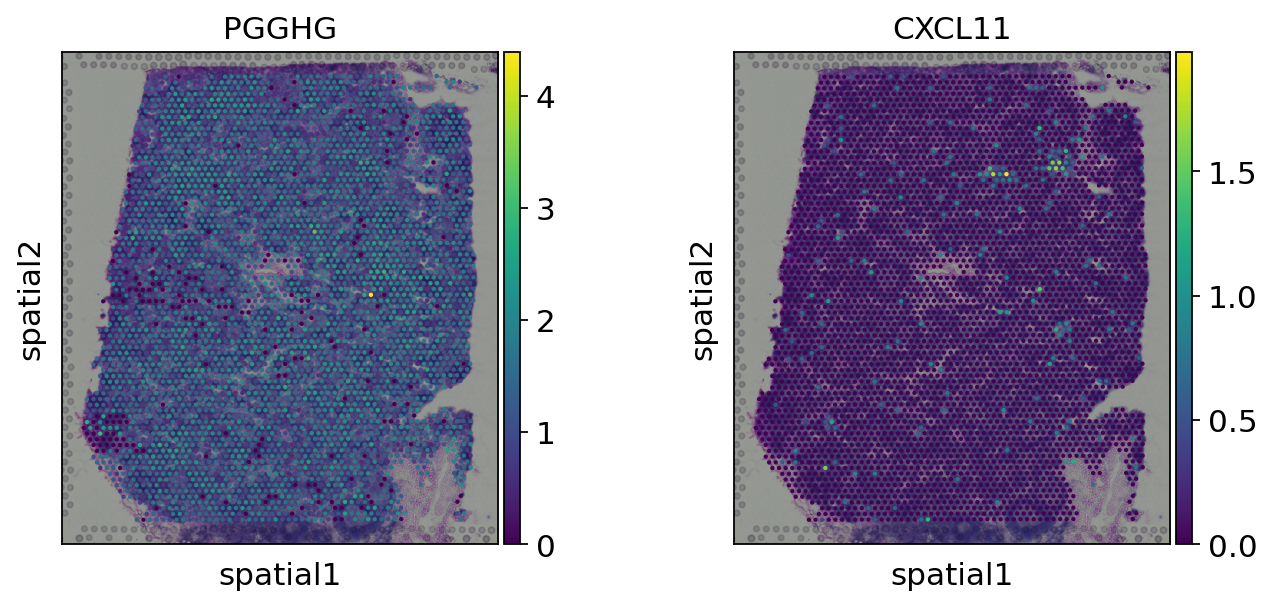

In [18]:
# Before enhancement
sc.pl.spatial(adata, color=svg_list[200:202], use_raw=False)

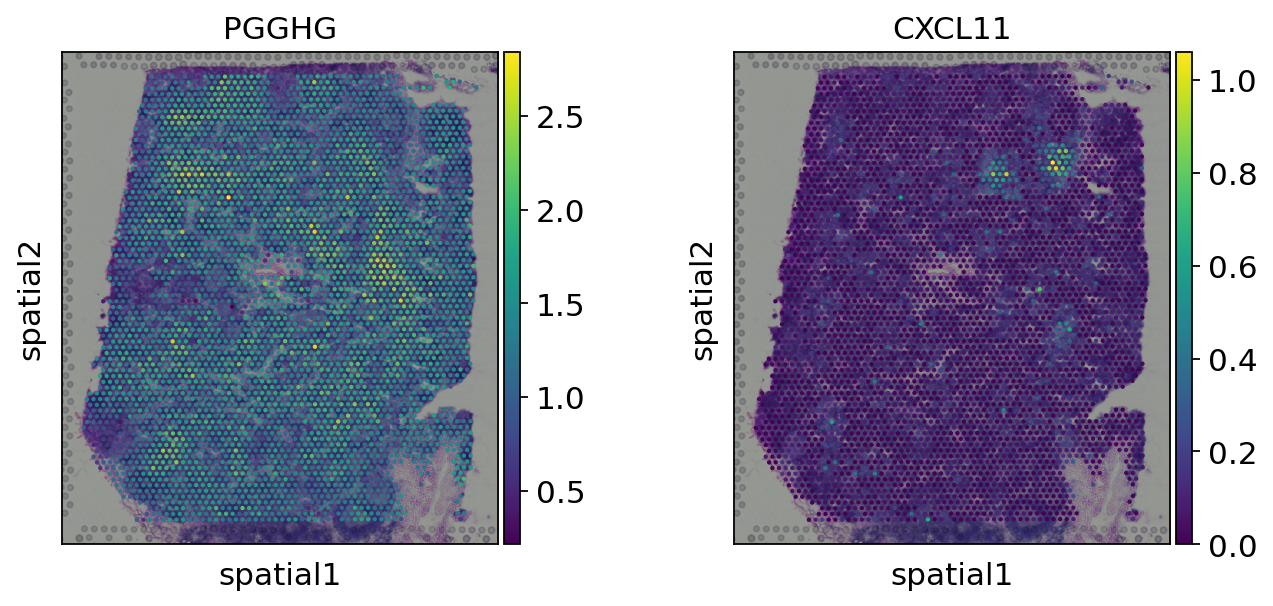

In [19]:
# After enhancement
sc.pl.spatial(new_adata, color=svg_list[200:202],use_raw=False)